<a href="https://colab.research.google.com/github/pedro00pt/Projeto-de-Big-Data/blob/main/Projeto_de_Big_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

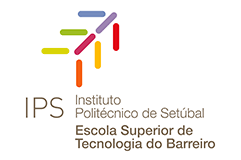

**Projeto de Big Data**

**Realizado por:**
**Pedro Peixoto nº202000221** **e**
**João Yanga nº202000167**

# **Índice**
 

*   Introdução
*   Instalação e configuração do Pyspark
*   Exploração e tratamento de dados
*   Implementação dos modelos
*   Conclusão
*   Bibliografia






# **Introdução**

No projeto final da unidade curricular de Big Data foi proposta a escolha de um dataset com a finalidade de aplicar as funcionalidades do Pyspark. O dataset escolhido trata-se de um conjunto de dados que consiste em mais de 1 milhão de transações feitas por cerca de 800 mil clientes de um banco indiano. O dataset tem 9 colunas com informações do ID do cliente, ID da transação, data de nascimento do cliente, localização, género, saldo da conta no momento da transação, data da transação, tempo de realização da transação e valor da transação.
O objetivo deste projeto foi usar o modelo K-means e uma regressão linear para entender possíveis padrões entre os saldos bancários dos clientes e os seus respetivos valores de transação. Pretende-se também comparar os resultados dos modelos.

# **Instalação e configuração do Pyspark**

Instalação do pyspark

In [ ]:
!pip install pyspark
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 10.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=d1cad868fe8adf20bd260d4642f545803d2f631c9a072a1ae83d6e711901658c
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importação das bibliotecas necessárias para o nosso projeto

In [ ]:
from pyspark.sql.functions import col, udf, count, asc, desc
from pyspark.sql.types import DoubleType, IntegerType, DateType, FloatType
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.functions import isnan, when, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

Inicialização de uma SparkSession.
Atribuiu-se o nome à nossa aplicação: Projeto de Big Data. 

In [ ]:
from pyspark.sql import SparkSession
import findspark

findspark.init()

spark = SparkSession.builder.appName("Projeto de Big Data")\
                    .config("spark.memory.offHeap.enabled","true")\
                    .config("spark.memory.offHeap.size","10g")\
                    .getOrCreate()




spark

Leitura do ficheiro csv dos dados bancários

In [ ]:
!curl https://raw.githubusercontent.com/pedro00pt/Projeto-de-Big-Data/main/bank_transactions-colunas_alinhadas.csv >> bank_transactions-colunas_alinhadas.csv
df = spark.read.csv('bank_transactions-colunas_alinhadas.csv',header=True,sep=";")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 66.8M  100 66.8M    0     0  59.5M      0  0:00:01  0:00:01 --:--:-- 59.5M


Retorna as 10 primeiras linhas do dataframe

In [ ]:
df.head(10)

[Row(TransactionID='T1', CustomerID='C5841053', CustomerDOB='10/1/94', CustGender='F', CustLocation='JAMSHEDPUR', CustAccountBalance='17819.05', TransactionDate='02/08/2016', TransactionTime='143207', TransactionAmount (INR)='25'),
 Row(TransactionID='T2', CustomerID='C2142763', CustomerDOB='4/4/57', CustGender='M', CustLocation='JHAJJAR', CustAccountBalance='2270.69', TransactionDate='02/08/2016', TransactionTime='141858', TransactionAmount (INR)='27999'),
 Row(TransactionID='T3', CustomerID='C4417068', CustomerDOB='26/11/96', CustGender='F', CustLocation='MUMBAI', CustAccountBalance='17874.44', TransactionDate='02/08/2016', TransactionTime='142712', TransactionAmount (INR)='459'),
 Row(TransactionID='T4', CustomerID='C5342380', CustomerDOB='14/9/73', CustGender='F', CustLocation='MUMBAI', CustAccountBalance='866503.21', TransactionDate='02/08/2016', TransactionTime='142714', TransactionAmount (INR)='2060'),
 Row(TransactionID='T5', CustomerID='C9031234', CustomerDOB='24/3/88', CustGe

Mostra as 5 primeiras linhas do dataframe no formato de uma tabela com linhas e colunas

In [ ]:
df.show(5,0)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|T1           |C5841053  |10/1/94    |F         |JAMSHEDPUR  |17819.05          |02/08/2016     |143207         |25                     |
|T2           |C2142763  |4/4/57     |M         |JHAJJAR     |2270.69           |02/08/2016     |141858         |27999                  |
|T3           |C4417068  |26/11/96   |F         |MUMBAI      |17874.44          |02/08/2016     |142712         |459                    |
|T4           |C5342380  |14/9/73    |F         |MUMBAI      |866503.21         |02/08/2016     |142714         |2060                   |
|T5           |C9031234  |24/3/88 

# **Exploração e Tratamento de dados**

Informações gerais do dataframe:
*   Número de linhas
*   Número total de transações
*   Número total de clientes

Verificou-se que várias colunas eram do tipo string quando não o deveriam ser, visto que se tratam de dados bancários como o saldo da conta e o montante de transação. Fizeram-se então as devidas alterações dos tipos de dados.
Viu-se de seguida se as colunas do dataframe contêm valores nulos e na's.

In [ ]:
df.count()

1046198

In [ ]:
df.select('TransactionID').distinct().count()

1048567

In [ ]:
df.select('CustomerID').distinct().count()

884265

In [ ]:
df = df \
    .withColumn('CustomerDOB', col('CustomerDOB').cast(DateType())) \
    .withColumn('CustAccountBalance', col('CustAccountBalance').cast(FloatType())) \
    .withColumn('TransactionDate', col('TransactionDate').cast(DateType())) \
    .withColumn('TransactionTime', col('TransactionTime').cast(IntegerType())) \
    .withColumn('TransactionAmount (INR)', col('TransactionAmount (INR)').cast(FloatType()))

In [ ]:
df_Columns=["TransactionID","CustomerID","CustGender","CustLocation","CustAccountBalance","TransactionTime","TransactionAmount (INR)"]
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df_Columns]).show()

+-------------+----------+----------+------------+------------------+---------------+-----------------------+
|TransactionID|CustomerID|CustGender|CustLocation|CustAccountBalance|TransactionTime|TransactionAmount (INR)|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+
|            0|         0|      1100|         151|              2369|              0|                      0|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+



In [ ]:
df_Columns=["TransactionID","CustomerID","CustGender","CustLocation","CustAccountBalance","TransactionTime","TransactionAmount (INR)"]
df.select([count(when(isnan(c), c)).alias(c) for c in df_Columns]).show()

+-------------+----------+----------+------------+------------------+---------------+-----------------------+
|TransactionID|CustomerID|CustGender|CustLocation|CustAccountBalance|TransactionTime|TransactionAmount (INR)|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+
|            0|         0|         0|           0|                 0|              0|                      0|
+-------------+----------+----------+------------+------------------+---------------+-----------------------+



Foram retirados os valores nulos das colunas CustAccountBalance e TransactionAmount (INR).
Foram obtidos valores para parâmetros estatísticos para cada uma das colunas do dataframe, excluindo as colunas CustomerDOB e TransactionDate que são do tipo data.
Imprimiram-se as informações das colunas do dataframe para verficar se as alterações foram feitas corretamente.

In [ ]:
from pyspark.sql.functions import col

df = df.filter(col("CustAccountBalance").isNotNull())

In [ ]:
from pyspark.sql.functions import col

df = df.filter(col("TransactionAmount (INR)").isNotNull())

In [ ]:
df.describe().show()

+-------+-------------+----------+----------+--------------------+------------------+------------------+-----------------------+
|summary|TransactionID|CustomerID|CustGender|        CustLocation|CustAccountBalance|   TransactionTime|TransactionAmount (INR)|
+-------+-------------+----------+----------+--------------------+------------------+------------------+-----------------------+
|  count|      1046198|   1046198|   1045098|             1046047|           1046198|           1046198|                1046198|
|   mean|         null|      null|      null|            400012.0|115403.54003532871|157093.97752911015|     1573.2668660781317|
| stddev|         null|      null|      null|                 0.0| 846485.3813218848|51262.217088456826|      6569.715131284188|
|    min|           T1|  C1010011|         F|(154) BHASKOLA FA...|               0.0|                 0|                    0.0|
|    max|      T999999|  C9099956|         T|           ZUNHEBOTO|      1.15035496E8|            

In [ ]:
df.printSchema()

root
 |-- TransactionID: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- CustomerDOB: date (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: float (nullable = true)
 |-- TransactionDate: date (nullable = true)
 |-- TransactionTime: integer (nullable = true)
 |-- TransactionAmount (INR): float (nullable = true)



Aplicaram-se algumas transformações ao dataframe original para um melhor entendimento dos dados:

*   Dataframe que apresenta as 10 primeiras linhas referentes aos clientes que contêm um saldo bancário superior a 5000 rupias indianas.  
*   Dataframe que apresenta as 10 primeiras linhas referentes às transações que demoraram menos de 500 segundos a serem feitas.
*   Dataframe que mostra o número de clientes por género. 
*   Top 10 dos locais com maior número de clientes.
*   Top 80 dos clientes com maior saldo bancário, com informação do género e dos locais.
*   Top 10 dos locais com maior saldo bancário médio.

In [ ]:
new_df_CustAccountBalanceBiggerThan5000 = df.filter(df.CustAccountBalance > 5000)
new_df_CustAccountBalanceBiggerThan5000.show(10)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|           T1|  C5841053|       null|         F|  JAMSHEDPUR|          17819.05|           null|         143207|                   25.0|
|           T3|  C4417068|       null|         F|      MUMBAI|          17874.44|           null|         142712|                  459.0|
|           T4|  C5342380|       null|         F|      MUMBAI|          866503.2|           null|         142714|                 2060.0|
|           T5|  C9031234|       null|         F| NAVI MUMBAI|           6714.43|           null|         181156|                 1762.5|
|           T6|  C1536588|       n

In [ ]:
new_df_TransactionTimeLessThan500 = df.filter(df.TransactionTime < 500)
new_df_TransactionTimeLessThan500.show(10)

+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|TransactionID|CustomerID|CustomerDOB|CustGender|CustLocation|CustAccountBalance|TransactionDate|TransactionTime|TransactionAmount (INR)|
+-------------+----------+-----------+----------+------------+------------------+---------------+---------------+-----------------------+
|        T5126|  C1214190|       null|         F|        DURG|            401.44|           null|            400|                  110.0|
|       T20397|  C3222875|       null|         M|  VIJAYAWADA|          16511.74|           null|             10|                  330.0|
|       T21305|  C6228180|       null|         M|    DINDIGUL|             70.09|           null|            113|                   10.0|
|       T35040|  C8916035|       null|         M|   BANGALORE|          19298.99|           null|            357|                1538.81|
|       T35041|  C6432239|       n

In [ ]:
new_df_PessoasPorGenero = df.groupby('CustGender')
new_df_PessoasPorGenero.count().show(10)

+----------+------+
|CustGender| count|
+----------+------+
|         F|281272|
|      null|  1100|
|         M|763825|
|         T|     1|
+----------+------+



In [ ]:
df.groupBy('CustLocation').agg(countDistinct('CustomerID').alias('count')).orderBy(desc('count')).show(10)

+------------+------+
|CustLocation| count|
+------------+------+
|      MUMBAI|101473|
|   NEW DELHI| 83371|
|   BANGALORE| 80264|
|     GURGAON| 72788|
|       DELHI| 69870|
|       NOIDA| 32493|
|     CHENNAI| 29749|
|        PUNE| 25632|
|   HYDERABAD| 22889|
|       THANE| 21336|
+------------+------+
only showing top 10 rows



In [ ]:
df.createOrReplaceTempView("Top80AccountBalance")
query = '''SELECT CustomerID, CustGender, CustLocation, CustAccountBalance FROM Top80AccountBalance ORDER BY CustAccountBalance DESC'''
spark.sql(query).show(80)

+----------+----------+------------+------------------+
|CustomerID|CustGender|CustLocation|CustAccountBalance|
+----------+----------+------------+------------------+
|  C3316830|         M|    SHILLONG|      1.15035496E8|
|  C6416825|         M|    SHILLONG|      1.15035496E8|
|  C4316889|         M|    SHILLONG|      1.15035496E8|
|  C2216823|         M|    SHILLONG|      1.15035496E8|
|  C5916881|         M|    SHILLONG|      1.15035496E8|
|  C5116828|         M|    SHILLONG|      1.15035496E8|
|  C2916887|         M|    SHILLONG|      1.15035496E8|
|  C7716886|         M|    SHILLONG|      1.15035496E8|
|  C2916865|         M|    SHILLONG|      1.15035496E8|
|  C8116818|         M|    SHILLONG|      1.15035496E8|
|  C5914453|         F|     GURGAON|       8.2244632E7|
|  C2514473|         F|     GURGAON|       8.2244632E7|
|  C4014424|         F|     GURGAON|       8.2244632E7|
|  C6914429|         F|     GURGAON|       8.2244632E7|
|  C3414471|         F|     GURGAON|       8.224

In [ ]:
top10 = df.groupBy("CustLocation").agg(avg("CustAccountBalance")) \
          .orderBy(avg("CustAccountBalance"), ascending=False) \
          .limit(10)
top10.createOrReplaceTempView("temp_view")
top10.show()

+--------------------+-----------------------+
|        CustLocation|avg(CustAccountBalance)|
+--------------------+-----------------------+
|  PO BOX 28483 DUBAI|             2.169666E7|
|              RENTON|            2.0773104E7|
|   SULTANATE OF OMAN|            1.6599123E7|
|MERCEDES SHOWROOM...|              7567497.5|
|            SHILLONG|      7240424.006631125|
|              AHMADI|              7090440.5|
|SOMAJIGUDA HYDERABAD|              6503694.0|
|       BORIVALI WEST|              6011185.5|
|              SAKAKA|              5441524.5|
|(W) NEAR RAMDEV M...|              5208462.5|
+--------------------+-----------------------+



Foi feita uma alteração do nome da coluna TransactionAmount (INR) para TransactionAmount. O printSchema() confirma a alteração.
Aplicou-se ainda mais uma transformação:
*   Top 50 dos maiores montantes transacionados, com informação do ID do cliente, género, local e saldo bancário. 

In [ ]:
df = df.withColumnRenamed('TransactionAmount (INR)', 'TransactionAmount')

In [ ]:
df.printSchema()

root
 |-- TransactionID: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- CustomerDOB: date (nullable = true)
 |-- CustGender: string (nullable = true)
 |-- CustLocation: string (nullable = true)
 |-- CustAccountBalance: float (nullable = true)
 |-- TransactionDate: date (nullable = true)
 |-- TransactionTime: integer (nullable = true)
 |-- TransactionAmount: float (nullable = true)



In [ ]:
df.createOrReplaceTempView("Top50TransactionAmount")
query = '''SELECT CustomerID, CustGender, CustLocation, CustAccountBalance, TransactionAmount FROM Top50TransactionAmount ORDER BY TransactionAmount DESC'''
spark.sql(query).show(50)

+----------+----------+-----------------+------------------+-----------------+
|CustomerID|CustGender|     CustLocation|CustAccountBalance|TransactionAmount|
+----------+----------+-----------------+------------------+-----------------+
|  C7319271|         M|          GURGAON|          42487.89|        1560035.0|
|  C6677159|         F|             PUNE|          98660.33|        1380002.9|
|  C4141768|         M|        NEW DELHI|           83608.1|        991132.25|
|  C8217728|         M|           MUMBAI|       6.1382212E7|         724122.0|
|  C1830891|         F|          KOLKATA|          14177.65|         720001.2|
|  C6549785|         F|            NOIDA|          29198.46|         600008.3|
|  C5036642|         M|        NEW DELHI|          136294.6|        600003.44|
|  C4328064|         F|            DELHI|          38735.17|        569500.25|
|  C1425138|         M|           MUMBAI|           9324.35|         561001.0|
|  C5833636|         M|PALAKKARAI TRICHY|         14

Gráfico circular relativo ao género dos clientes:

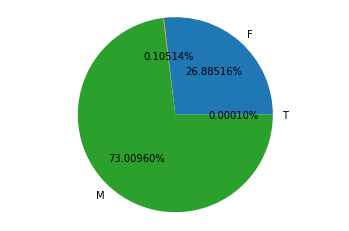

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Agrupa as contagens dos géneros
gender_counts = df.groupBy("CustGender").count()

# Extrai os dados como listas
genders = gender_counts.select("CustGender").rdd.flatMap(lambda x: x).collect()
counts = gender_counts.select("count").rdd.flatMap(lambda x: x).collect()

# Cria o gráfico circular
plt.pie(counts, labels=genders, autopct='%1.5f%%')
plt.axis('equal')
plt.show()


Os valores que perfazem 0.1% são nulos. 73% dos clientes do banco são do sexo masculino, 26.9% são do sexo feminino. A letra T no gráfico é relativo aos clientes do banco que não se identificam com nenhum dos dois géneros mencionados acima. 
Verifica-se uma diferença significativa entre a proporção dos clientes que são do sexo feminino e do sexo masculino, sendo que os clientes deste banco são predominantemente homens.

# **Implementação dos modelos**

**Algoritmo de K-means**

In [ ]:
# Cria um vetor assembler para combinar as colunas "CustAccountBalance" e "TransactionAmount" num único vetor
vectorAssembler = VectorAssembler(inputCols=["CustAccountBalance", "TransactionAmount"], outputCol="unscaled_features")

# Usa o vetor assembler para transformar o dataframe
df_kmeans = vectorAssembler.transform(df)

# Cria um objeto de scaling para standardizar os dados
scaler = StandardScaler(inputCol="unscaled_features", outputCol="features", withStd=True, withMean=True)

# Ajusta o scaler aos dados e transforma o dataframe
scalerModel = scaler.fit(df_kmeans)
df_kmeans = scalerModel.transform(df_kmeans)

# Instancia o algoritmo K-means com o número de clusters pretendido
kmeans = KMeans(k=3, seed=1)

# Ajusta o modelo aos dados
model = kmeans.fit(df_kmeans)

# Faz a previsão dos clusters
predictions = model.transform(df_kmeans)

# Apresenta os resultados
predictions.select("CustAccountBalance", "TransactionAmount","prediction").show()

+------------------+-----------------+----------+
|CustAccountBalance|TransactionAmount|prediction|
+------------------+-----------------+----------+
|          17819.05|             25.0|         0|
|           2270.69|          27999.0|         0|
|          17874.44|            459.0|         0|
|          866503.2|           2060.0|         0|
|           6714.43|           1762.5|         0|
|           53609.2|            676.0|         0|
|            973.46|            566.0|         0|
|          95075.54|            148.0|         0|
|          14906.96|            833.0|         0|
|           4279.22|           289.11|         0|
|          48429.49|            259.0|         0|
|          14613.46|            202.0|         0|
|          32274.78|          12300.0|         0|
|          59950.44|             50.0|         0|
|          10100.84|            338.0|         0|
|           1283.12|            250.0|         0|
|          77495.15|          1423.11|         0|


Se as previsões dos clusters de um output de k-means têm valores de 0, isso pode significar que os dados associados a essas respetivas previsões não foram atribuídos a nenhum cluster. Isso acontece quando os dados não se encaixam em nenhum dos clusters criados pelo algoritmo, ou se o algoritmo não consegue encontrar nenhum cluster significativo nos dados.
Por isso não conseguimos concluir que haja alguma relação significativa entre as colunas "CustAccountBalance" e "TransactionAmount" com o uso deste algoritmo.

**Algoritmo de Regressão Linear**

In [ ]:
# Cria o objeto VectorAssembler para agrupar as colunas numa única coluna de vetores
assembler = VectorAssembler(inputCols=["CustAccountBalance", "TransactionAmount"], outputCol="features2")

# Ajusta o assembler ao dataframe
df_vec = assembler.transform(df)

# Cria o objeto StandardScaler
scaler = StandardScaler(inputCol="features2", outputCol="scaledFeatures", withStd=True, withMean=True)

# Ajusta o scaler ao dataframe
scaled_df = scaler.fit(df_vec).transform(df_vec)


In [ ]:
from pyspark.ml.regression import LinearRegression

# Cria o objeto LinearRegression
lr = LinearRegression(featuresCol="scaledFeatures", labelCol="CustAccountBalance", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Aplica o método train-test split 
train_df, test_df = scaled_df.randomSplit([0.7, 0.3])

# Treina o modelo
model = lr.fit(train_df)

# Testa o modelo
predictions = model.transform(test_df)


In [ ]:
# Aplica o modelo aos dados de teste
predictions = model.transform(test_df)

# Apresenta as previsões
predictions.select("prediction").show()


+------------------+
|        prediction|
+------------------+
| 594924.6401793947|
| 89396.05608246283|
|162420.98298525836|
| 29958.16141013382|
|39973.835548023795|
| 7198.698879605567|
| 83446.28478144042|
| 189796.2387801964|
|0.6213080653687939|
|6638.6087486946635|
| 2010.760556972993|
| 4253.959702644206|
| 28444.90023477422|
| 65078.34606460393|
| 36853.90698084542|
|180874.52323385657|
| 34734.95852297945|
| 92476.65653876337|
|5414.6594811660325|
| 52506.13182910584|
+------------------+
only showing top 20 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Cria o objeto RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="CustAccountBalance", predictionCol="prediction", metricName="rmse")

# Calcula o RMSE
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 0.336888


In [ ]:
# Acede ao summary do modelo
summary = model.summary

# Obtém o R²
r2 = summary.r2

# Exibe o R²
print("R-squared value:", r2)


R-squared value: 0.9999999999998711


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Cria o objeto RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="CustAccountBalance", predictionCol="prediction", metricName="mae")

# Calcula o MAE
mae = evaluator.evaluate(predictions)
print("Mean Absolute Error (MAE) on test data = %g" % mae)


Mean Absolute Error (MAE) on test data = 0.0578793


In [ ]:
# Cria o objeto RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="CustAccountBalance", predictionCol="prediction", metricName="mse")

# Calcula o MSE
mse = evaluator.evaluate(predictions)
print("Mean Squared Error (MSE) on test data = %g" % mse)


Mean Squared Error (MSE) on test data = 0.113494


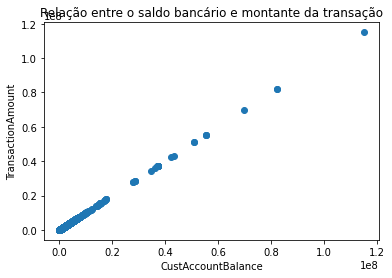

In [ ]:
import matplotlib.pyplot as plt

# Extrai as colunas obtidas da previsão e a label do dataframe
predictions_col = predictions.select("prediction").toPandas()
label_col = predictions.select("CustAccountBalance").toPandas()

# Constrói o gráfico das previsões em relação aos valores reais
plt.scatter(label_col, predictions_col)
plt.xlabel("CustAccountBalance")
plt.ylabel("TransactionAmount")
plt.title("Relação entre o saldo bancário e montante da transação")
plt.show()

Ao observar o gráfico é possível perceber que existe uma relação proporcional entre o saldo bancário dos clientes e os seus respetivos valores de transação. 

O que indica que quanto maior o saldo bancário, maior será a quantia de transação.

# **Conclusão**

No final deste projeto, observaram-se diferenças nos resultados dos modelos. O K-means não permitiu chegar a uma conclusão concreta, já a regressão linear aponta para uma forte relação proporcional entre o saldo bancário de um cliente e o valor da sua transação.
Este trabalho permitiu consolidar os conceitos aprendidos nesta unidade curricular.

# **Bibliografia**




*   [An introduction to clustering](https://www.analyticsvidhya.com/blog/2016/11/an-introduction-to-clustering-and-different-methods-of-clustering//)
*   [Clustering](https://spark.apache.org/docs/latest/ml-clustering.html)


*   [Unix Time Stamp](https://www.unixtimestamp.com/)
*   [Linear Regression](https://towardsdatascience.com/introduction-to-machine-learning-algorithms-linear-regression-14c4e325882a)



